# ConvVAE MNISTdataset

In the previous notebook we have seen the implementation of a Dense VAE. Now we see a Conv VAE (i.e. CVAE).

https://www.tensorflow.org/tutorials/generative/cvae

In [1]:
# Utilities
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# Import keras dataset Mnist
from tensorflow.keras.datasets import mnist

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Normalization

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Adding the channels dimension

In [4]:
x_train = np.reshape(x_train, (60000, 28, 28, 1)) 

x_test = np.reshape(x_test, (10000, 28, 28, 1))

### Latent dimension

We decide since now the dimensionality of $z$: $16$.

In [5]:
latent_dim = 16

### Sampling function

We define the sampling function. Given the mean $\mu(z|X)$ and std $\sigma(z|X)$ produced by the encoder, it samples a latent encoding $z$, which is the variable to give to the generator.

$z$ is computed as $\mu(z|X)+\sigma(z|X)*\epsilon$, where $\epsilon$ is sampled from the normal distribution $N(0,1)$.

It is important to remark that we are talking about multivariate distributions: $z$, $\mu(z|X)$, $\sigma(z|X)$ and $\epsilon$ are vectors of values. They are all vectors of dimensions $16$.

In [6]:
def sampling(inputs):
    z_mean, z_log_var = inputs
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### Encoder

The encoder takes in input an image: $28x28x1$ values. Structured input.

We produce two outputs: the mean $\mu(z|X)$ and the std $\sigma(z|X)$. Both of them are flat vectors with $16$ values.

Actually, the encoder produces the log-variance $log(\sigma(z|X)^2)$ instead of the std $\sigma(z|X)$.

The structure is the following.
- Some Conv layers
- Flattening
- Dense layer for producing $\mu(z|X)$ and Dense layer for producing $log(\sigma(z|X)^2)$.

In [13]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras import Model

In [74]:
# Input image x
xin = Input(shape=(28,28,1))

# Conv layers
x = Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(xin)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)

# Flattening from 7x7x32 to 1568
x = Flatten()(x)

# Producing the mean and the log-variance
z_mean = Dense(units=latent_dim)(x)  # From 1568 values to 16
z_log_var = Dense(units=latent_dim)(x)  # From 1568 values to 16

# Encoder model
encoder = Model(inputs=xin, outputs=[z_mean, z_log_var], name='Encoder')

In [75]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 14, 14, 16)   160         ['input_19[0][0]']               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 7, 7, 32)     4640        ['conv2d_12[0][0]']              
                                                                                                  
 flatten_4 (Flatten)            (None, 1568)         0           ['conv2d_13[0][0]']              
                                                                                            

### Decoder

It takes as input a latent encoding $z$: dimension $16$. It generates a reconstructed image $\hat{X}$: dimensions $28x28x1$. 

The last layer of the decoder uses the **sigmoid** activation function, since we want values between $0$ and $1$.

So, it starts from a flat input of dimension $16$, and it generates a structured output of dimensions $28x28x1$.

For doing so, we follow this pattern.
1. Input $z$: dimension $16$.
2. Dense layer, producing $7*7*32=1568$ values.

Now, we want to increase the spatial dimensions. For doing so, we use Transposed Conv layers.

3. Reshaping from flat dimension $1568$ to dimensions $14, 14, 32$. 
4. Transposed Conv layer, with output dimensions $28, 28, 16$.
5. Transposed Conv layer, with output dimensions $28, 28, 1$. The output is the generated image $\hat{X}$. THe activation function is **sigmoid**, beacuse we want to generate values in the range $[0,1]$.

Very simmetric with respect to the encoder.

The decoder is our generator.

The structure is the following.
- 

In [52]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

In [76]:
# Input: latent encoding z
zin = Input(shape=(latent_dim,))

# Dense layer: from 16 values to 1568
z = Dense(units=1568)(zin)

# Reshaping from 1568 to 7x7x32
z = Reshape((7, 7, 32))(z)

# Transpose Conv layers
z = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(z)
z = Conv2DTranspose(filters=16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(z)

# Generated image
x_hat = Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(1,1), padding='same', activation='sigmoid')(z)

decoder = Model(inputs=zin, outputs=x_hat, name='Decoder')

In [77]:
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_13 (Dense)            (None, 1568)              26656     
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 14, 14, 32)       9248      
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 28, 28, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 28, 28, 1)        145 

### Sampling layer

Between the encoder and the decoder, we have to put the sampling operation: fiven the mean $\mu(z|X)$ and the log-variance $log(\sigma(z|X)^2)$, it generates a sample $z$.

This is implemented using a layer. In particular, in keras we can use the `lambda` layer for building a layer starting from a function. (In our case, the `sampling` function).

In [23]:
from tensorflow.keras.layers import Lambda

### VAE model

Finally, let's define the VAE model.
1. We use the encoder as a single layer.
2. We define the sampling layer.
3. We use the decoder as a single layer.

In [78]:
x = Input(shape=(28,28,1))

z_mean, z_log_var = encoder(x)

z = Lambda(function=sampling, output_shape=(latent_dim,), name='Sampling')([z_mean, z_log_var])

x_hat = decoder(z)

vae = Model(inputs=x, outputs=x_hat, name='VAE')

In [79]:
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Encoder (Functional)           [(None, 16),         55008       ['input_21[0][0]']               
                                 (None, 16)]                                                      
                                                                                                  
 Sampling (Lambda)              (None, 16)           0           ['Encoder[0][0]',                
                                                                  'Encoder[0][1]']                
                                                                                                

### Loss function

Sum between two components: reconstruction error and KL divergence.

In [68]:
from tensorflow.keras import metrics

In [80]:
# We define our loss function
rec_loss = 784 * metrics.binary_crossentropy(tf.reshape(x,shape=[-1]), tf.reshape(x_hat,shape=[-1]))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + kl_loss)

In [81]:
# We add the loss into our model
vae.add_loss(vae_loss)

### Compile

In [82]:
vae.compile(optimizer='adam')

### Training

In [83]:
batch_size = 100
epochs = 50

In [84]:
vae.fit(x_train, None, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
600/600 [==============================] - 23s 36ms/step - loss: 164.6727 - val_loss: 117.9775
Epoch 2/50
600/600 [==============================] - 23s 38ms/step - loss: 114.7415 - val_loss: 110.3856
Epoch 3/50
600/600 [==============================] - 21s 35ms/step - loss: 109.9513 - val_loss: 107.5480
Epoch 4/50
600/600 [==============================] - 21s 35ms/step - loss: 107.7055 - val_loss: 105.8013
Epoch 5/50
600/600 [==============================] - 22s 36ms/step - loss: 106.2333 - val_loss: 105.1759
Epoch 6/50
600/600 [==============================] - 21s 35ms/step - loss: 105.2029 - val_loss: 104.2280
Epoch 7/50
600/600 [==============================] - 25s 41ms/step - loss: 104.4876 - val_loss: 103.3176
Epoch 8/50
600/600 [==============================] - 23s 38ms/step - loss: 103.8351 - val_loss: 102.9411
Epoch 9/50
600/600 [==============================] - 22s 37ms/step - loss: 103.3393 - val_loss: 102.5149
Epoch 10/50
600/600 [=========================

Better loss value with respect to the Dense VAE.

### Generating MNIST images

Now we want to generate some MNIST images. How to do that?

The decoder is our generator. Given a latent encoding $z$, it generates an image $\hat{X}$ compliant with our dataset: so, a MNIST image.

The latent encoding $z$ is sampled from the latent space $N(0,1)$.

We want to generate $n$ MNIST images.

In [85]:
n = 10

In [86]:
# Sample of n latent vectors 'z'. Each of them is a vector with 'latent_dim' values.
z_sample = np.random.normal(size=(n, latent_dim))
print('z_sample shape:', z_sample.shape)

# n generated MNISt images
generated_images = decoder.predict(z_sample)
print('generated_images shape:', generated_images.shape)

z_sample shape: (10, 16)
generated_images shape: (10, 28, 28, 1)


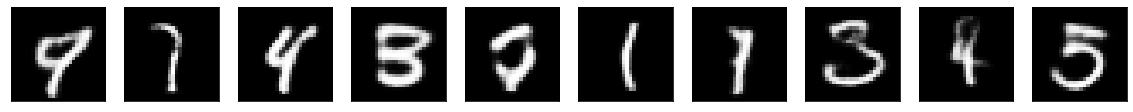

In [87]:
plt.figure(figsize=(2*n, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(generated_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Another generation of $10$ images.

In [118]:
# Sample of n latent vectors 'z'. Each of them is a vector with 'latent_dim' values.
z_sample = np.random.normal(size=(n, latent_dim))
print('z_sample shape:', z_sample.shape)

# n generated MNISt images
generated_images = decoder.predict(z_sample)
print('generated_images shape:', generated_images.shape)

z_sample shape: (10, 16)
generated_images shape: (10, 28, 28, 1)


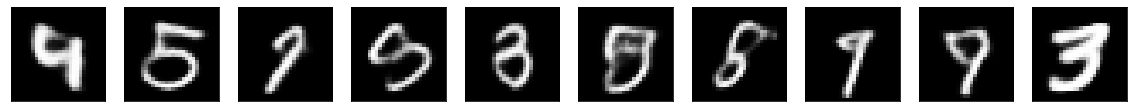

In [119]:
plt.figure(figsize=(2*n, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(generated_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Qualitative better than Dense VAE.